<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
!unzip mltle.zip
!pip install scikit-plot
!pip install lifelines
!pip install tensorflow-addons

Archive:  mltle.zip
   creating: mltle/
   creating: mltle/data/
  inflating: mltle/datagen.py        
  inflating: mltle/datamap.py        
  inflating: mltle/data/maps.py      
 extracting: mltle/data/__init__.py  
   creating: mltle/data/__pycache__/
  inflating: mltle/data/__pycache__/maps.cpython-38.pyc  
  inflating: mltle/data/__pycache__/__init__.cpython-38.pyc  
  inflating: mltle/training.py       
  inflating: mltle/__init__.py       
   creating: mltle/__pycache__/
  inflating: mltle/__pycache__/datagen.cpython-38.pyc  
  inflating: mltle/__pycache__/datamap.cpython-38.pyc  
  inflating: mltle/__pycache__/training.cpython-38.pyc  
  inflating: mltle/__pycache__/__init__.cpython-38.pyc  
     |████████████████████████████████| 349 kB 16.8 MB/s 
     |████████████████████████████████| 68 kB 5.7 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=c363782959299f5257a9

In [2]:
import scikitplot as skplt
from sklearn.metrics import mean_squared_error
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow_addons as tfa

In [3]:
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback
from tqdm.auto import tqdm

from collections import defaultdict

import pandas as pd
import numpy as np
from keras import backend as K

import tensorflow as tf

tqdm.pandas()

In [4]:
import mltle as mlt

In [5]:
###### Experiment


SEED = 7

NUM_RES_BLOCKS = 2
NUM_EPOCHS = 10
DISCOUNT = 0.6
BATCH_SIZE = 128

In [6]:
tf.keras.backend.clear_session()
np.random.seed(SEED)
tf.random.set_seed(SEED)

model = mlt.training.Model(drug_emb_size=128,
              protein_emb_size=64,
              max_drug_len=200,
              drug_alphabet_len=53,
              protein_alphabet_len=8006)

order = ['p1Ki', 'p1IC50', 'p1Kd', 'p1EC50', 'is_active', 'pH', 'pSL']
loss_weights = [1.0] * len(order)

variables = {}
for var in order:
    variables[var] = K.variable(0.0)

LossCallback = mlt.training.LossWithMemoryCallback(variables, discount=DISCOUNT, decay = 0.8)

uselosses = defaultdict(lambda: mlt.training.mse_loss_wrapper)
uselosses['is_active'] = 'binary_crossentropy'

for k, v in variables.items():
    if k not in uselosses.keys():
        uselosses[k] = uselosses[k](v)

usemetrics = {'is_active': tf.keras.metrics.AUC()}

activations = defaultdict(lambda: 'linear')
activations['is_active'] = 'sigmoid'


initializer = tf.keras.initializers.VarianceScaling(scale=1., mode='fan_in', distribution='normal', seed=SEED)
optimizer = tfa.optimizers.Lookahead(tf.keras.optimizers.Nadam(), sync_period=3)

model = model.create_model(order=order,
                            activations=activations,
                            activation = 'relu',
                            pooling_mode = 'max',
                            num_res_blocks=NUM_RES_BLOCKS,
                            units_per_head=64,
                            units_per_layer=256,
                            dropout_rate=0.3,
                            drug_kernel=(2, 3),
                            protein_kernel=(7, 7),
                            loss_weights=loss_weights,
                            usemetrics=usemetrics,
                            uselosses=uselosses,
                            initializer=initializer,
                            optimizer=optimizer,
                            drug_strides_up=1,
                            protein_strides_down=1)

Done. Total params: 979463


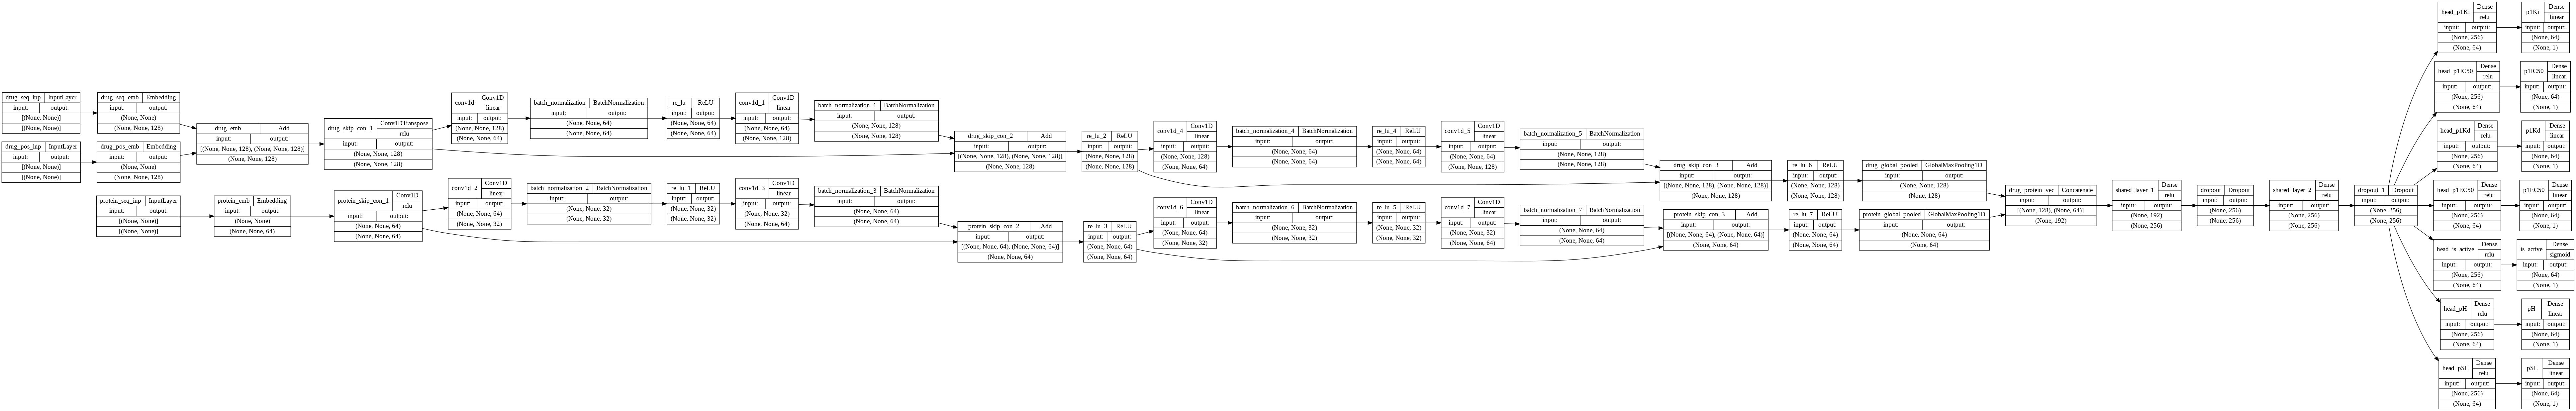

In [7]:
tf.keras.utils.plot_model(model,
                          rankdir='LR',
                          show_shapes=True,
                          show_layer_activations=True,
                          dpi=96)

In [8]:
data = pd.read_csv("data_human_agg05_pH.zip", compression='zip')
data = data[['smiles', 'target'] + order[:-1]]
data['pSL'] = data['smiles'].str.len().apply(np.log1p)
data = data.sample(frac=1, random_state = 7)

In [9]:
scalers = {}

for col in order:
    if col != 'is_active':
        scalers[col] = (data[col].mean(), data[col].std())
        data[col] = (data[col] - scalers[col][0]) / scalers[col][1]

In [10]:
scalers 

{'p1EC50': (6.6991552132594085, 3.4146611427924753),
 'p1IC50': (6.222363739412311, 3.2845626926865283),
 'p1Kd': (7.406605389206093, 2.9553907556293555),
 'p1Ki': (5.216629547117468, 3.3350513699056767),
 'pH': (7.233874948393005, 0.7588319291764479),
 'pSL': (3.9499097321689645, 0.31910880607176384)}

In [11]:
data.head(2)

,smiles,target,p1Ki,p1IC50,p1Kd,p1EC50,is_active,pH,pSL
618389,Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5ccccc5)CC...,MPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIK...,NaN,0.304294,NaN,NaN,0.0,NaN,0.291880
30622,CCCNC(=O)C1CC(c2ccc(C(F)(F)F)cc2)=NO1,MIFLYQVVHFILFTSVSGECVTQLLKDTCFEGGDITTVFTPSAKYC...,NaN,1.018297,NaN,NaN,0.0,0.218922,-0.978737


In [12]:
mapseq = mlt.datamap.MapSeq(drug_mode='smiles_1',
                protein_mode='protein_3',
                max_drug_len=200)

drug_seqs, protein_seqs = data['smiles'].unique(), data['target'].unique()

map_drug, map_protein = mapseq.create_maps(drug_seqs = drug_seqs, protein_seqs = protein_seqs)

  0%|          | 0/574406 [00:00<?, ?it/s]

  0%|          | 0/1902 [00:00<?, ?it/s]

In [ ]:
# print(list(map_drug.values())[0])

In [ ]:
# print(list(map_protein.values())[0])

In [13]:
X_train, X_test = train_test_split(data,
                                   test_size=0.1,
                                   shuffle=True,
                                   random_state=7,
                                   stratify=data['is_active'])

X_train, X_valid = train_test_split(X_train,
                                    test_size=0.1,
                                    shuffle=True,
                                    random_state=7,
                                    stratify=X_train['is_active'])

X_train.shape[0], X_test.shape[0], X_valid.shape[0]

(733937, 90610, 81549)

In [14]:
batch_size = BATCH_SIZE

train_gen = mlt.datagen.DataGen(X_train, map_drug, map_protein)
train_gen = train_gen.get_generator(batch_size)

valid_gen = mlt.datagen.DataGen(X_valid, map_drug, map_protein)
valid_gen = valid_gen.get_generator(batch_size)

In [ ]:
# for batch in train_gen:
#     break
    
# batch

In [15]:
steps_per_epoch = X_train.shape[0] // batch_size
valid_steps = X_valid.shape[0] // batch_size

In [16]:
filepath = "Res2_06_{epoch:02d}-{val_is_active_auc:.5f}.h5"
CheckPointCallback = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                monitor='val_is_active_auc',
                                                verbose=1,
                                                save_best_only=False,
                                                mode='auto',
                                                save_weights_only=True)


CSVLoggerCallback = tf.keras.callbacks.CSVLogger("Res2_06.log")

In [ ]:
history = model.fit(train_gen,
                    validation_data=valid_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=valid_steps,
                    verbose=0,
                    callbacks=[TqdmCallback(), CheckPointCallback, LossCallback, CSVLoggerCallback],
                    epochs=NUM_EPOCHS)

In [ ]:
[f"{k} : {float(v)}" for k, v in variables.items()]

In [17]:
model.load_weights('Res2_06_08-0.88027.h5')
model.compile()
model.save("Res2_06.hdf5")

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.title('Loss on train-valid subsets')
plt.legend()

In [18]:
def get_batch_size(S):
    mbs = 1
    for i in range(1, min(128, S)):
        if S % i == 0:
            mbs = i
    assert S % mbs == 0

    return mbs

In [19]:
test_batch_size = get_batch_size(X_test.shape[0])
test_batch_size 

85

In [21]:
test_gen = mlt.datagen.DataGen(X_test,
                               map_drug,
                               map_protein,
                               shuffle=False,
                               test_only=True)

test_gen = test_gen.get_generator(test_batch_size)

In [22]:
prediction = model.predict(test_gen, steps=X_test.shape[0] // test_batch_size , verbose=1)

1066/1066 [==============================] - 857s 802ms/step


In [23]:
def get_scores(y_true, y_pred):
    mse = np.round(mean_squared_error(y_true, y_pred), 3)
    rmse = np.round(mse**0.5, 3)
    ci = np.round(concordance_index(y_true, y_pred), 3)
    pearson = np.round(stats.pearsonr(y_true, y_pred)[0], 3)
    spearman = np.round(stats.spearmanr(y_true, y_pred)[0], 3)

    res = f"rmse={rmse}, mse={mse},\npearson={pearson}, spearman={spearman},\nci={ci}"

    return res

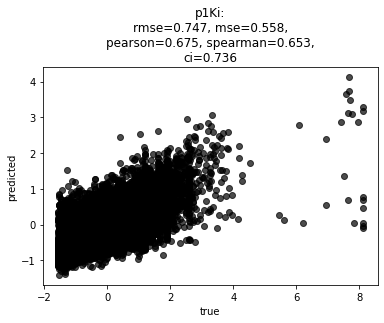

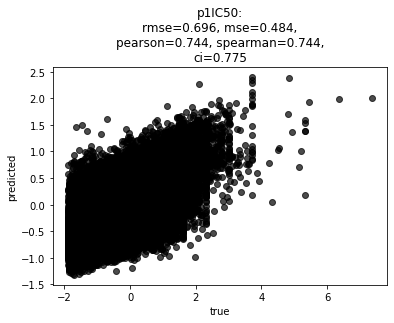

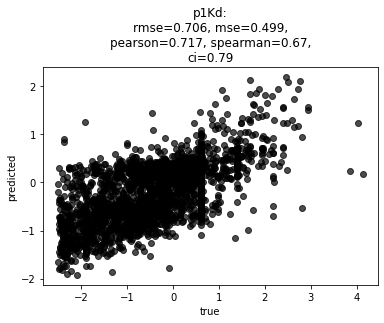

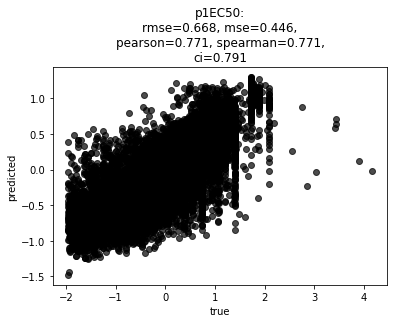

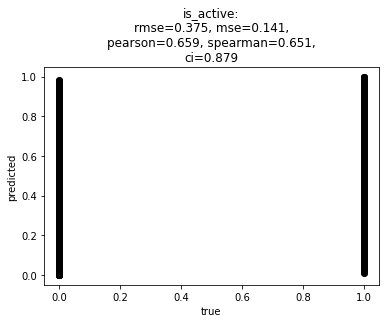

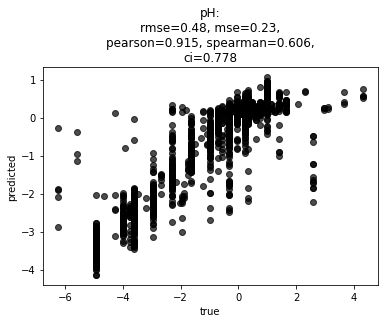

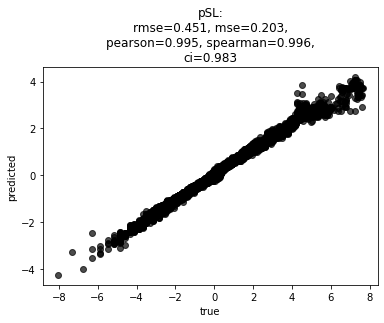

In [24]:
for k, col in enumerate(order):
    plt.scatter(X_test[col], prediction[k], alpha=0.7, c='k')
    plt.xlabel('true')
    plt.ylabel('predicted')
    y_true = X_test[col][X_test[col].notna()]
    y_pred = prediction[k][X_test[col].notna()].ravel()
    plt.title(col + ":\n" + get_scores(y_true, y_pred))
    plt.show()

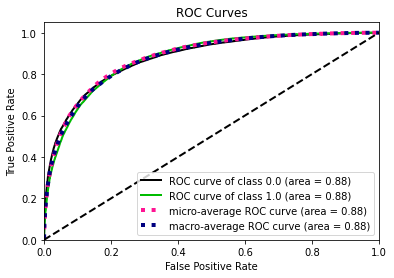

In [25]:
p = prediction[order.index('is_active')].ravel().tolist()
probas = np.zeros((len(p), 2))
probas[:, 1] = p
probas[:, 0] = 1
probas[:, 0] = probas[:, 0] - p
skplt.metrics.plot_roc(X_test['is_active'].values.ravel().tolist(), probas)
plt.show()

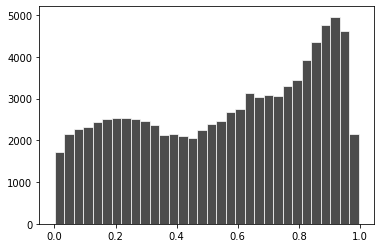

In [26]:
h = plt.hist(prediction[order.index('is_active')].ravel(),
             bins=32,
             edgecolor='w',
             color='k',
             alpha=0.7)